# MCGrad Core Algorithm Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookincubator/MCGrad/blob/main/tutorials/01_mcgrad_core.ipynb)

This tutorial provides a comprehensive introduction to **MCGrad** (Multicalibration Gradient Boosting), a powerful algorithm for calibrating machine learning predictions across arbitrary population segments.

You can find more information about MCGrad at [mcgrad.dev](https://mcgrad.dev).

We demonstrate MCGrad using data from the American Community Survey, training a logistic regression model to predict binary employment status. You'll see how the base model can suffer from multicalibration error, and how MCGrad can fix it.

## Outline

1. **Setup** - Download the ACS employment dataset and train a logistic regression model
2. **Assessing Model Performance, Calibration and Multicalibration** - Introduce multicalibration, how to measure it, and demonstrate that global calibration methods can fail to address it
3. **MCGrad Basics** - Fit MCGrad to fix multicalibration error
4. **Model Evaluation** - Use MCGrad's plotting and evaluation tools to compare base model, global calibration, and MCGrad
5. **Advanced Features** - Hyperparameter tuning, MCE metric details, and serialization for production use

## 1. Setup

MCGrad must be installed. See the [installation guide](https://facebookincubator.github.io/MCGrad/) for instructions.

In [ ]:
# Setup for Colab
import sys
if 'google.colab' in sys.modules:
    # Install MCGrad
    !pip install -q "MCGrad[tutorials] @ git+https://github.com/facebookincubator/MCGrad.git"
    # Download helper module
    !wget -q https://raw.githubusercontent.com/facebookincubator/MCGrad/tutorial_notebooks/tutorials/helpers.py

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split

from mcgrad import metrics, methods, plotting

To keep this tutorial compact, helper functions are located in `helpers.py` in this directory.

In [ ]:
from helpers import (
    BINARY_COLUMNS,
    CATEGORICAL_COLUMNS,
    LABEL_COLUMN,
    NUMERICAL_COLUMNS,
    combine_segment_calibration_plots,
    configure_logging,
    create_logistic_pipeline,
    format_calibration_metrics_table,
    load_acs_employment_data,
    setup_plotting,
)

In [ ]:
# Notebook setup
setup_plotting()
configure_logging()

### 1.1 Dataset and ML task

We use a sample of the American Community Survey (ACS) dataset containing information on respondents' *employment status* (binary: employed/unemployed) along with sociodemographic features:

| Column Name | Description |
|-------------|-------------|
| AGEP | Age of the individual (in years) |
| SCHL | Educational attainment (ordinal code for highest level of schooling) |
| MAR | Marital status |
| RELP | Relationship to the household reference person |
| DIS | Disability status indicator |
| ESP | English-speaking ability (limited English proficiency indicator) |
| CIT | Citizenship status |
| MIG | Mobility status (whether the person lived in the same house 1 year ago) |
| MIL | Military service status |
| ANC | Ancestry (self-reported primary ancestry) |
| NATIVITY | Nativity (U.S.-born vs foreign-born) |
| DEAR | Hearing difficulty indicator |
| DEYE | Vision difficulty indicator |
| DREM | Cognitive difficulty indicator |
| SEX | Sex |
| RAC1P | Race (single-race category) |
| **employment_label** | Employment status (binary target variable) |

In [ ]:
employment_df = load_acs_employment_data(states=["TX", "MI", "PA"])
employment_df.head()

Dataset has 496585 samples


,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,employment_label
0,21.0,16.0,5,17,2,0,1,1,4,1,1,2,2,2,2,2,True
1,19.0,16.0,5,17,2,0,1,1,4,1,1,2,2,2,2,1,False
2,24.0,12.0,5,16,1,0,1,1,4,1,1,2,2,1,1,2,False
3,20.0,16.0,5,17,2,0,1,1,3,1,1,2,2,2,2,1,True
4,31.0,17.0,5,17,2,0,1,3,4,4,1,2,2,2,1,1,True


We split the data into training and test sets, separating features from labels.

In [ ]:
train_df, test_df = train_test_split(
    employment_df, test_size=0.30, random_state=42, stratify=employment_df[LABEL_COLUMN]
)

X_train = train_df.drop(columns=[LABEL_COLUMN])
y_train = train_df[LABEL_COLUMN].astype(int).to_numpy()

X_test = test_df.drop(columns=[LABEL_COLUMN])
y_test = test_df[LABEL_COLUMN].astype(int).to_numpy()

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 347609, Test: 148976


### 1.2 Train the base model

We train a logistic regression model using all features to predict employment status. The pipeline applies standard scaling to numerical features and one-hot encoding to categorical features. See `helpers.py` for implementation details.

In [ ]:
logistic_pipeline = create_logistic_pipeline()
logistic_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('binary', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differ

## 2. Assessing Model Performance, Calibration and Multicalibration

A model is *calibrated* if its predicted probabilities match observed frequencies—e.g., among all predictions of 0.7, roughly 70% should be positive. We evaluate the base model's predictive performance and calibration on the test set.

We also generate predictions on the training set, which we'll use later to train the calibration methods.

In [ ]:
BASE_MODEL_PREDICTION_COLUMN = 'base_model_prediction'
test_df[BASE_MODEL_PREDICTION_COLUMN] = logistic_pipeline.predict_proba(test_df.drop(columns=[LABEL_COLUMN]))[:,1]
train_df[BASE_MODEL_PREDICTION_COLUMN] = logistic_pipeline.predict_proba(train_df.drop(columns=[LABEL_COLUMN]))[:,1]

Let's first examine the model's predictive performance. We compute the area under the precision-recall curve (PRAUC), the area under the ROC curve (ROCAUC), and log-loss.

### 2.1 Discriminative Performance

In [ ]:
evaluation_metrics = {
    "PRAUC": skmetrics.average_precision_score,
    "ROCAUC": skmetrics.roc_auc_score,
    "log-loss": skmetrics.log_loss,
}

perf_metrics = {
    metric_name: metric_func(
        test_df[LABEL_COLUMN].values,
        test_df[BASE_MODEL_PREDICTION_COLUMN].values,
    )
    for metric_name, metric_func in evaluation_metrics.items()
}
pd.DataFrame.from_dict(perf_metrics, orient='index').rename(columns={0: 'base_model'}).round(3)

,base_model
PRAUC,0.824
ROCAUC,0.880
log-loss,0.421


The base model shows strong discriminative performance (ROCAUC ≈ 0.88, PRAUC ≈ 0.82). Now let's assess calibration quality.

### 2.2 Global Calibration

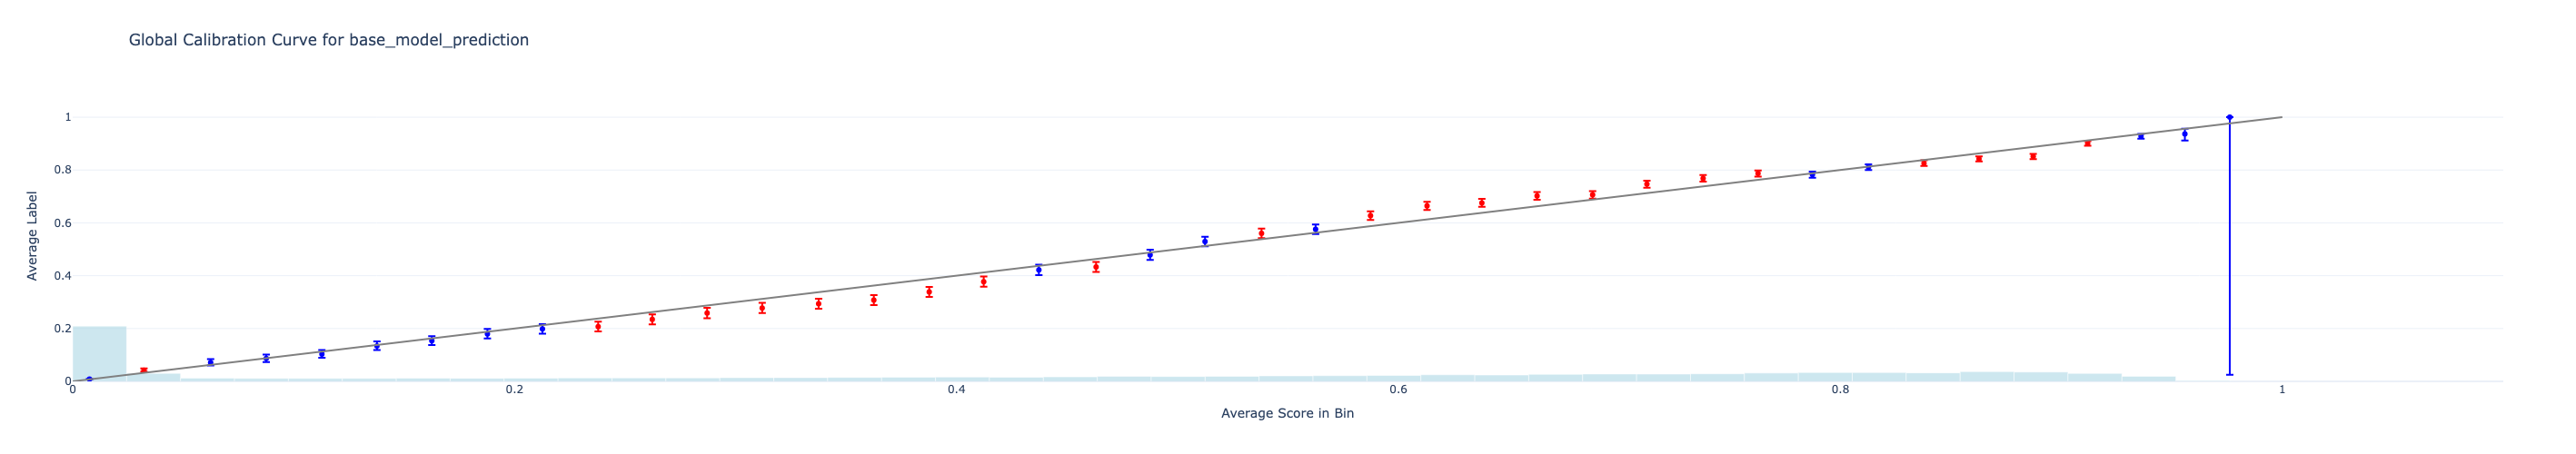

In [ ]:
plotting.plot_global_calibration_curve(
    data=test_df,
    score_col=BASE_MODEL_PREDICTION_COLUMN,
    label_col=LABEL_COLUMN,
    num_bins=40,
).update_layout(title=f"Global Calibration Curve for {BASE_MODEL_PREDICTION_COLUMN}", width=700, height=500)

The light blue histogram shows the distribution of predicted scores. The calibration curve is computed by binning predictions and calculating the proportion of positive labels in each bin. A perfectly calibrated model produces points along the 45° diagonal. The 95% confidence intervals help distinguish statistically significant miscalibration from noise.

Our logistic regression model shows decent global calibration, but some score ranges deviate significantly from the diagonal—the model systematically over- or under-predicts employment probability in certain regions.

To quantify this, we use the **Expected Cumulative Calibration Error (ECCE)**, which doesn't rely on bin count and has well-understood statistical properties. See the [methodology documentation](https://facebookincubator.github.io/MCGrad/docs/measuring-multicalibration) for details.

The ECCE distribution under perfect calibration is known analytically, allowing us to compute a "sigma scale"—the number of standard deviations the observed error lies from zero. Values above 5σ roughly indicate significant miscalibration. We access these metrics using `ecce` and `ecce_sigma` in the `metrics` submodule:

In [ ]:
def compute_ecce_with_sigma(labels, predictions):
    return metrics.ecce(labels, predictions), metrics.ecce_sigma(labels, predictions)

In [ ]:
ecce_base_model, ecce_sigma_base_model = compute_ecce_with_sigma(test_df[LABEL_COLUMN].values, test_df[BASE_MODEL_PREDICTION_COLUMN].values)

print(f"Global miscalibration of the base model:\nECCE: {ecce_base_model:.4f}, ({ecce_sigma_base_model:.2f} sigmas)")

Global miscalibration of the base model:
ECCE: 0.0085, (8.74 sigmas)


The ECCE is 0.0085 on the probability scale, corresponding to 8.7σ—strong statistical evidence of global miscalibration. The model's calibration can be improved.

We can fix global miscalibration using standard calibration methods like isotonic regression. MCGrad provides several such methods in the `methods` module.

In [ ]:
isotonic_regression = methods.IsotonicRegression().fit(
    train_df,
    BASE_MODEL_PREDICTION_COLUMN,
    LABEL_COLUMN,
)

In [ ]:
IR_SCORE_COL = 'score_isotonic_regression'
test_df[IR_SCORE_COL] = isotonic_regression.predict(
    test_df,
    BASE_MODEL_PREDICTION_COLUMN,
)

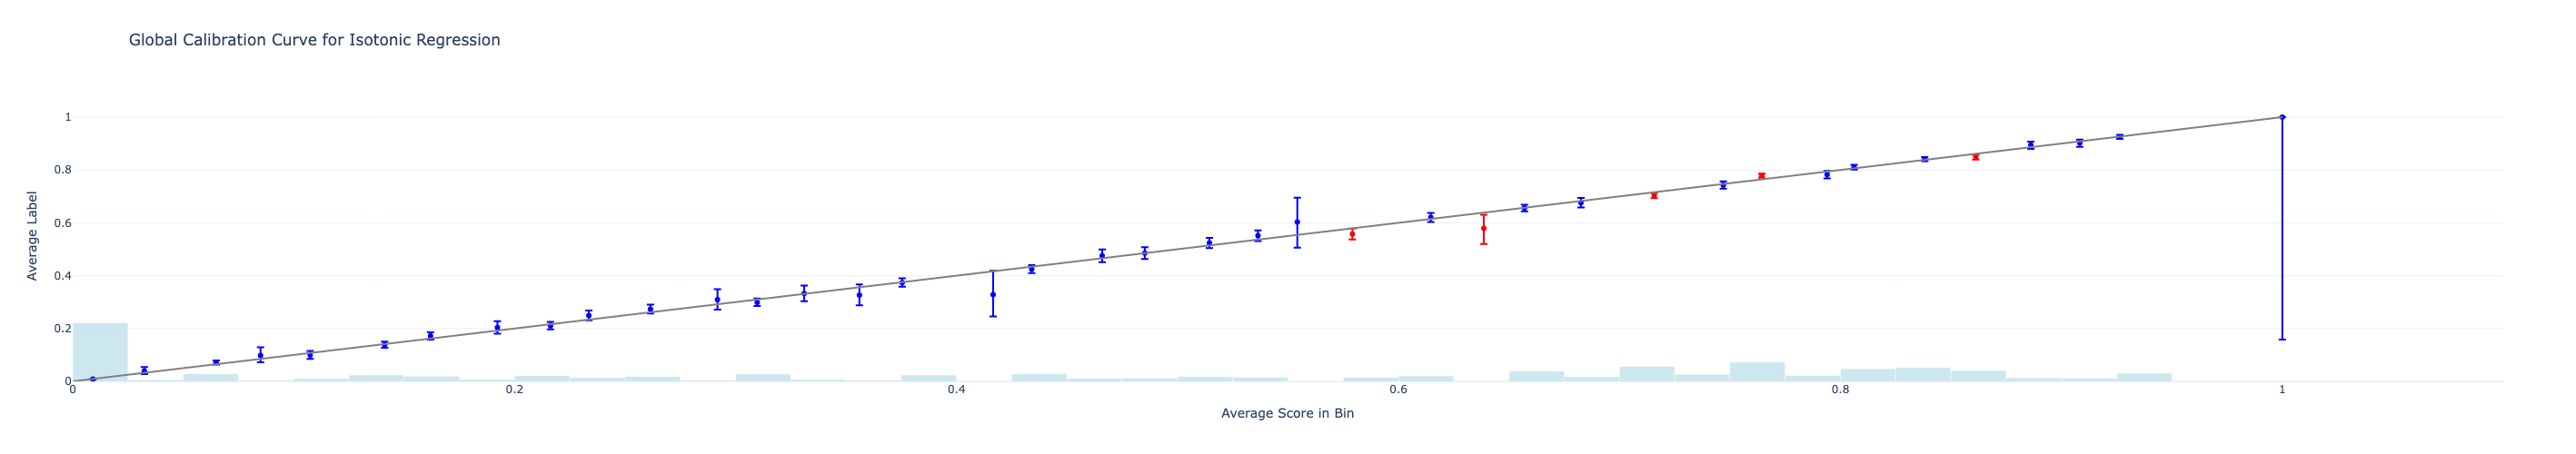

In [ ]:
plotting.plot_global_calibration_curve(
    data=test_df,
    score_col=IR_SCORE_COL,
    label_col=LABEL_COLUMN,
    num_bins=40,
).update_layout(title=f"Global Calibration Curve for Isotonic Regression", width=700, height=500)

Isotonic regression fixed the global miscalibration successfully. Only a few buckets deviate significantly from the diagonal—for 40 bins we expect about 2 significant deviations at 95% confidence. Let's verify with the ECCE metric:

In [ ]:
ecce_ir, ecce_sigma_ir = compute_ecce_with_sigma(test_df[LABEL_COLUMN].values, test_df[IR_SCORE_COL].values)

print(f"Global miscalibration after isotonic regression:\nECCE: {ecce_ir:.6f}, ({ecce_sigma_ir:.2f} sigmas)")

Little evidence of global miscalibration remains. The calibration error dropped substantially, and the sigma scale suggests further improvement is unlikely given the dataset size. So we're done, right?

### 2.3 Multicalibration

Not quite. While the model is calibrated *on average*, let's examine subsets of the data using `plot_calibration_curve_by_segment`. How well is the model calibrated for men vs. women?

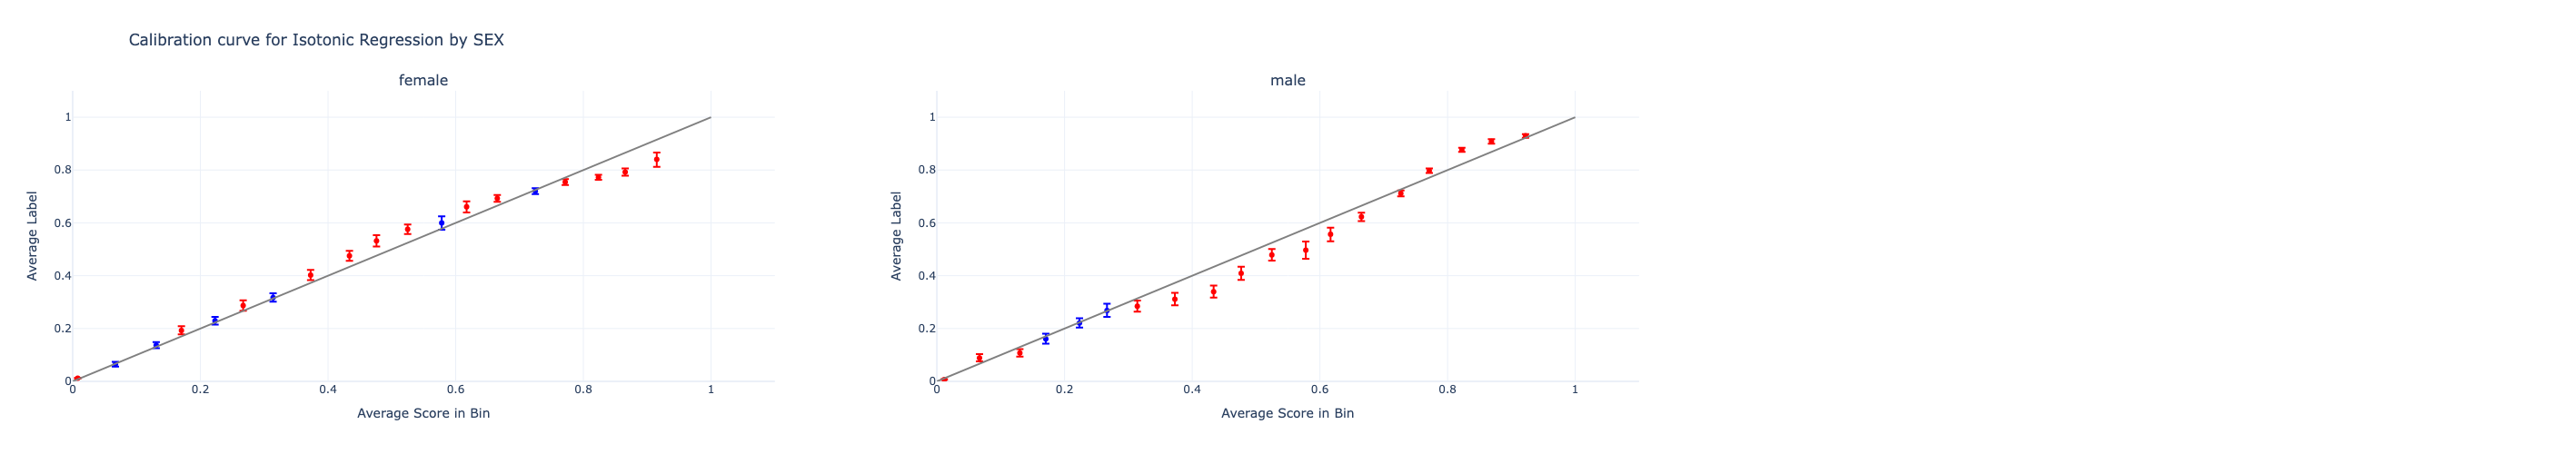

In [ ]:
plot_feature = "SEX"
plotting.plot_calibration_curve_by_segment(
    # Rename codes in place
    test_df.astype({plot_feature: 'object'}).replace({plot_feature: {1: 'male', 2: 'female'}}),
    group_var=plot_feature,
    score_col=IR_SCORE_COL,
    label_col=LABEL_COLUMN,
    n_cols=3,
).update_layout(
    title=f"Calibration curve for Isotonic Regression by {plot_feature}",
    width=2000,
    height=max(10.0, 500 * (np.ceil(len(test_df[plot_feature].unique()) / 3))),
)

We can also compute the ECCE for these two segments:

In [ ]:
male_test_df = test_df[test_df.SEX == 1]
female_test_df = test_df[test_df.SEX == 2]
ecce_ir_male, ecce_sigma_ir_male = compute_ecce_with_sigma(male_test_df[LABEL_COLUMN].values, male_test_df[IR_SCORE_COL].values)
ecce_ir_female, ecce_sigma_ir_female = compute_ecce_with_sigma(female_test_df[LABEL_COLUMN].values, female_test_df[IR_SCORE_COL].values)

print(f"Miscalibration after isotonic regression for male respondents:\nECCE: {ecce_ir_male:.4f}, ({ecce_sigma_ir_male:.2f} sigmas)")
print(f"Miscalibration after isotonic regression for female respondents:\nECCE: {ecce_ir_female:.4f}, ({ecce_sigma_ir_female:.2f} sigmas)")

Significant miscalibration persists when examining each sex separately. The errors are approximately symmetrical around the diagonal, canceling out at the global level.

Manually checking every possible sub-segment is impractical—what about females under 35? Males with disabilities who served in the military?

The [**Multicalibration Error (MCE)**](https://facebookincubator.github.io/MCGrad/docs/measuring-multicalibration) addresses this by computing the maximum ECCE across all segments. Let's compare the MCE for the base model and after isotonic regression:

In [ ]:
mce_base_model = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=BASE_MODEL_PREDICTION_COLUMN,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

mce_isotonic_regression = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=IR_SCORE_COL,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

print(f"MCE of the base model: {mce_base_model.mce:.4f} ({mce_base_model.mce_sigma:.2f} sigmas)")
print(f"MCE after isotonic regression: {mce_isotonic_regression.mce:.4f} ({mce_isotonic_regression.mce_sigma:.2f} sigmas)")

MCE of the base model: 0.0355 (36.71 sigmas)
MCE after isotonic regression: 0.0360 (37.53 sigmas)


Although isotonic regression nearly perfected global calibration, at least one segment still shows substantial miscalibration. The MCE after applying isotonic regression is almost as large as for the base model, and the sigma scale confirms this error is highly statistically significant.

To visualize calibration error across all segments considered by the MCE, we use `plot_segment_calibration_errors` to show ECCE σ for each segment. We compute plots for each score separately, then combine them with the helper function `combine_segment_calibration_plots`.

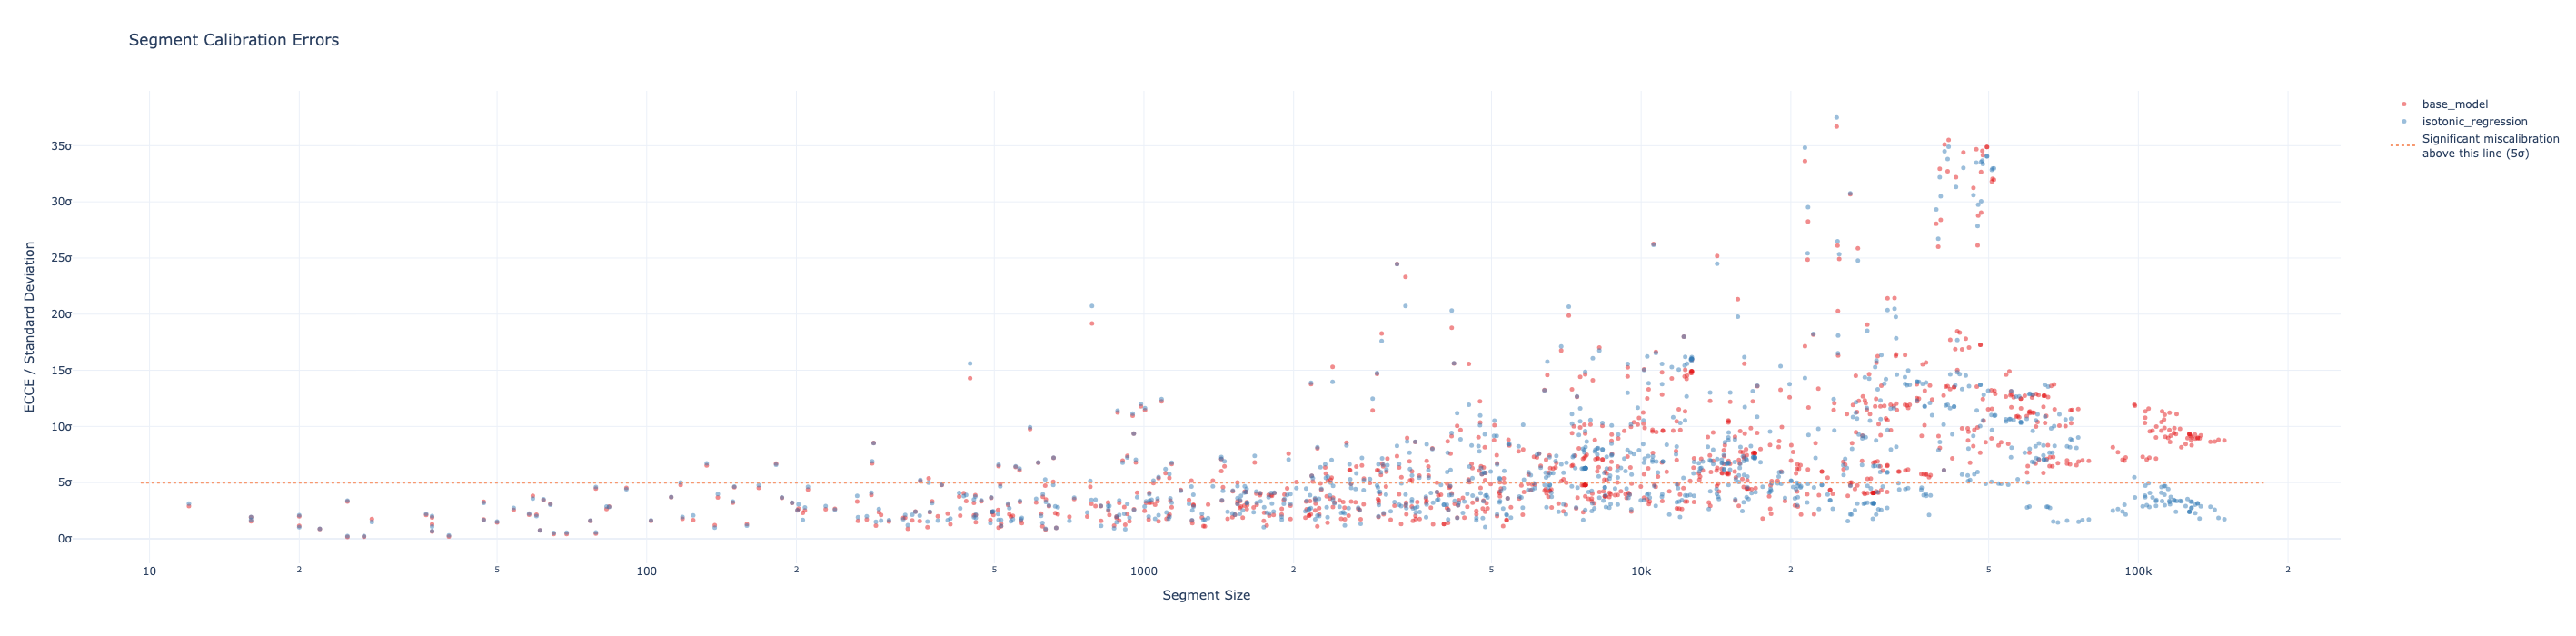

In [ ]:
segment_ecce_plots = {}

segment_ecce_plots["base_model"] = plotting.plot_segment_calibration_errors(
    mce=mce_base_model,
    quantity="segments_ecce_sigma",
).update_layout(width=700)

segment_ecce_plots["isotonic_regression"] = plotting.plot_segment_calibration_errors(
    mce=mce_isotonic_regression,
    quantity="segments_ecce_sigma",
).update_layout(width=700)

combine_segment_calibration_plots(
    segment_plots=segment_ecce_plots,
    quantity="segments_ecce_sigma",
).update_layout(height=700, width=1000)

Each dot represents a segment formed from the available features. Hover over a marker to see the feature values defining that segment. The value `"_all_"` means that feature is not used—all its values are included.

The segment with maximum miscalibration (36.7σ for the base model, 37.5σ for isotonic regression) is `SEX==1` and `AGEP==1`, i.e., male respondents in the middle third of the age distribution. AGEP uses quantile bins because it's a numerical feature split into three bins. See the `max_values_per_segment_feature` parameter in `MulticalibrationError` for details.

The global calibration error appears as the largest segment at the right end of the plot. When the global segment has the largest miscalibration, MCE equals ECCE.

**Takeaway**: A model can be nearly perfectly calibrated globally yet still have significant miscalibration in data subsets. In the next section we'll learn how to correct this.

## 3. MCGrad Basics

MCGrad is a multicalibration method based on gradient boosting that detects and corrects miscalibration in data subsets. See the [methodology documentation](https://facebookincubator.github.io/MCGrad/docs/methodology) for algorithmic details.

MCGrad requires specifying *segment features*—the features that can potentially define segments. For example, given features `sex`, `state`, and `age`, MCGrad can correct miscalibration for segments like "females in Pennsylvania over 30" as well as all other combinations.

Segment features are not explicit segment definitions; they're the building blocks from which segments are formed. MCGrad automatically considers all possible segments that can be constructed from the provided features.

Segment features must be declared as numerical or categorical:

In [ ]:
categorical_segment_features = CATEGORICAL_COLUMNS + BINARY_COLUMNS
numerical_segment_features = NUMERICAL_COLUMNS

In [ ]:
print(categorical_segment_features)

['MAR', 'RELP', 'CIT', 'MIG', 'MIL', 'ANC', 'RAC1P', 'DIS', 'ESP', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']


In [ ]:
print(numerical_segment_features)

['AGEP', 'SCHL']


MCGrad takes several configuration parameters. See the [API documentation](https://mcgrad.readthedocs.io/en/latest/api/methods.html#mcgrad.methods.MCGrad) for all constructor arguments. The default settings usually work well; here we make a few small tweaks:

- **`save_training_performance`**: Set to `True` to observe training performance alongside validation performance during early stopping cross-validation (see the learning curve plot below).
- **`lightgbm_params`**: MCGrad uses [LightGBM](https://lightgbm.readthedocs.io/en/stable/) under the hood. All LightGBM hyperparameters are available, though our tuned defaults usually suffice. Here we adjust the learning rate and number of trees per iteration to speed up fitting for this tutorial.

In [ ]:
mcgrad = methods.MCGrad(
    save_training_performance=True,
    lightgbm_params={'learning_rate': 0.1, 'n_estimators': 250},
)

In [ ]:
mcgrad = mcgrad.fit(
    train_df,
    BASE_MODEL_PREDICTION_COLUMN,
    LABEL_COLUMN,
    categorical_feature_column_names=categorical_segment_features,
    numerical_feature_column_names=numerical_segment_features,
)

[WARNING][2026-01-28 16:59:00][methods.py:1378]: Found 2981 (0.86%) predictions with extreme values (boundaries: [4.53979e-05, 0.999955]). These samples will be clipped in the unshrink step. Consider reviewing input prediction quality.
[INFO][2026-01-28 16:59:00][methods.py:549]: Preprocessing input data with 347609 rows; in_fit_phase = True
[INFO][2026-01-28 16:59:00][methods.py:648]: Early stopping activated, max_num_rounds=100 (timeout: 28800s)
[INFO][2026-01-28 16:59:00][methods.py:958]: Determining optimal number of rounds
[INFO][2026-01-28 16:59:00][methods.py:1282]: Found a relatively small effective sample size (347,609.0), choosing k-fold for early stopping. You can override this by explicitly setting `early_stopping_use_crossvalidation` to `False`.
[INFO][2026-01-28 16:59:00][methods.py:928]: Running early stopping using Cross Validation.
[INFO][2026-01-28 16:59:00][methods.py:948]: Using 5 folds for cross-validation.
[INFO][2026-01-28 16:59:00][methods.py:985]: Evaluating ro

MCGrad is an iterative method with integrated early stopping. We can inspect the training dynamics using `plot_learning_curve`:

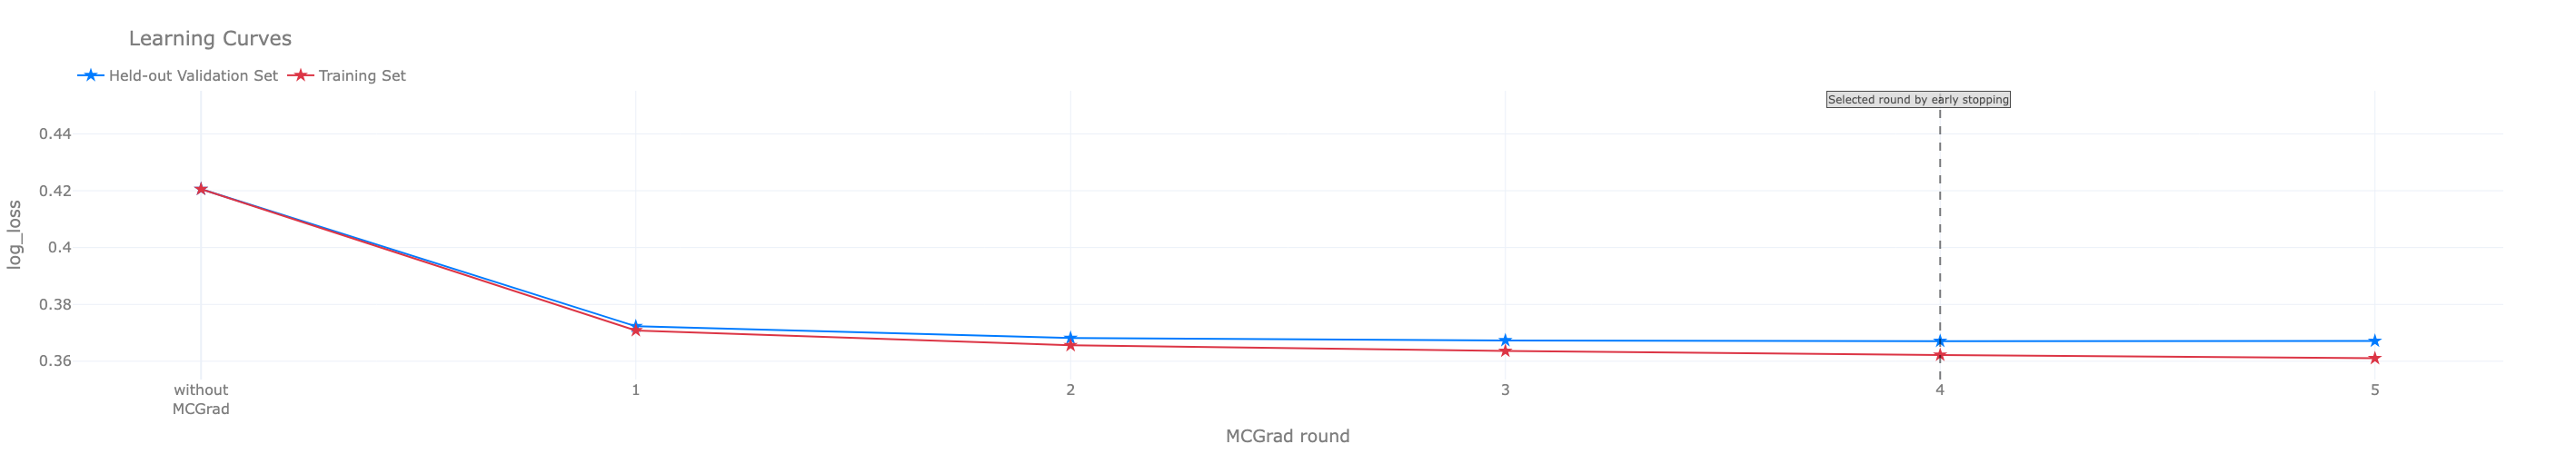

In [ ]:
plotting.plot_learning_curve(mcgrad, show_all=True).update_layout(width=700, height=500)

The learning curve shows healthy training dynamics: both training and validation loss decrease monotonically until early stopping triggers when they diverge. We see significant log-loss improvement over the base model (first point in the curve).

If MCGrad cannot improve over the base model, a built-in failsafe returns a "no-op predictor" that passes through the original predictions—useful in production pipelines with automatic retraining.

## 4. Model Evaluation

Let's generate MCGrad predictions to evaluate its performance.

In [ ]:
# Produce calibrated scores for all methods
MCGRAD_SCORE_COLUMN = "score_mcgrad"
test_df[MCGRAD_SCORE_COLUMN] = mcgrad.predict(
    df=test_df,
    prediction_column_name=BASE_MODEL_PREDICTION_COLUMN,
    categorical_feature_column_names=categorical_segment_features,
    numerical_feature_column_names=numerical_segment_features,
)

[INFO][2026-01-28 16:59:29][methods.py:549]: Preprocessing input data with 148976 rows; in_fit_phase = False


Before examining multicalibration across all segments, let's check calibration in the male and female segments:

In [ ]:
plot_feature = "SEX"
plotting.plot_calibration_curve_by_segment(
    # Rename codes in place
    test_df.astype({plot_feature: 'object'}).replace({plot_feature: {1: 'male', 2: 'female'}}),
    group_var=plot_feature,
    score_col=MCGRAD_SCORE_COLUMN,
    label_col=LABEL_COLUMN,
    n_cols=3,
).update_layout(
    title=f"Calibration curve for MCGrad by {plot_feature}",
    width=2000,
    height=max(10.0, 500 * (np.ceil(len(test_df[plot_feature].unique()) / 3))),
)

Calibration in both segments improved substantially. Let's compute the ECCE for each segment:

In [ ]:
male_test_df = test_df[test_df.SEX == 1]
female_test_df = test_df[test_df.SEX == 2]
ecce_mcgrad_male, ecce_sigma_mcgrad_male = compute_ecce_with_sigma(male_test_df[LABEL_COLUMN].values, male_test_df[MCGRAD_SCORE_COLUMN].values)
ecce_mcgrad_female, ecce_sigma_mcgrad_female = compute_ecce_with_sigma(female_test_df[LABEL_COLUMN].values, female_test_df[MCGRAD_SCORE_COLUMN].values)

print(f"Miscalibration after MCGrad for male respondents:\nECCE: {ecce_mcgrad_male:.4f}, ({ecce_sigma_mcgrad_male:.2f} sigmas)")
print(f"Miscalibration after MCGrad for female respondents:\nECCE: {ecce_mcgrad_female:.4f}, ({ecce_sigma_mcgrad_female:.2f} sigmas)")

Almost no evidence of miscalibration remains. Both segments have ECCEs within 3 standard deviations of what we'd expect from random variation in a perfectly calibrated model.

Now let's compare all metrics across the three methods: base model, isotonic regression, and MCGrad. First we compute the `MulticalibrationError` for the MCGrad predictions.

In [ ]:
mce_mcgrad = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=MCGRAD_SCORE_COLUMN,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

In [ ]:
evaluation_metrics = {
    "PRAUC": skmetrics.average_precision_score,
    "ROCAUC": skmetrics.roc_auc_score,
    "log_loss": skmetrics.log_loss,
}

perf_metrics = {}
segment_plots = {}
global_plots = {}
calibration_metrics = {}

for score, mce_obj in zip([BASE_MODEL_PREDICTION_COLUMN, IR_SCORE_COL, MCGRAD_SCORE_COLUMN], [mce_base_model, mce_isotonic_regression, mce_mcgrad]):
    print(f"Computing metrics for {score}")
    perf_metrics[score] = {
        metric_name: metric_func(
            test_df[LABEL_COLUMN].values,
            test_df[score].values,
        )
        for metric_name, metric_func in evaluation_metrics.items()
    }
    calibration_metrics[score] = {
        "ECCE": mce_obj.global_ecce,
        "ECCE " + "\u03c3": mce_obj.global_ecce_sigma,
        "MCE": mce_obj.mce,
        "MCE " + "\u03c3": mce_obj.mce_sigma,
    }

    fig = plotting.plot_global_calibration_curve(
        data=test_df,
        score_col=score,
        label_col=LABEL_COLUMN,
        num_bins=40,
    ).update_layout(title=f"Global Calibration Curve for {score}", width=700)
    global_plots[score] = fig
    segment_plots[score] = plotting.plot_segment_calibration_errors(
        mce=mce_obj, quantity="segments_ecce_sigma"
    ).update_layout(width=700)

In [ ]:
pd.DataFrame(perf_metrics).T.round(3)

,PRAUC,ROCAUC,log_loss
base_model_prediction,0.824,0.880,0.421
score_isotonic_regression,0.821,0.880,0.419
score_mcgrad,0.876,0.911,0.368


MCGrad improved both discriminative performance (lower log-loss) and ranking quality compared to the base model.

In [ ]:
format_calibration_metrics_table(calibration_metrics).round(3)

Calibration        Multicalibration        
                                 ECCE ECCE σ              MCE   MCE σ
base_model_prediction           0.008  8.745            0.036  36.706
score_isotonic_regression       0.002  1.745            0.036  37.525
score_mcgrad                    0.002  1.645            0.004   4.704

MCGrad eliminated statistically significant multicalibration error! The MCE (maximum segment miscalibration) dropped more than eight-fold, reaching the minimum detectable threshold of ~5σ. Let's visualize the segment-wise errors:

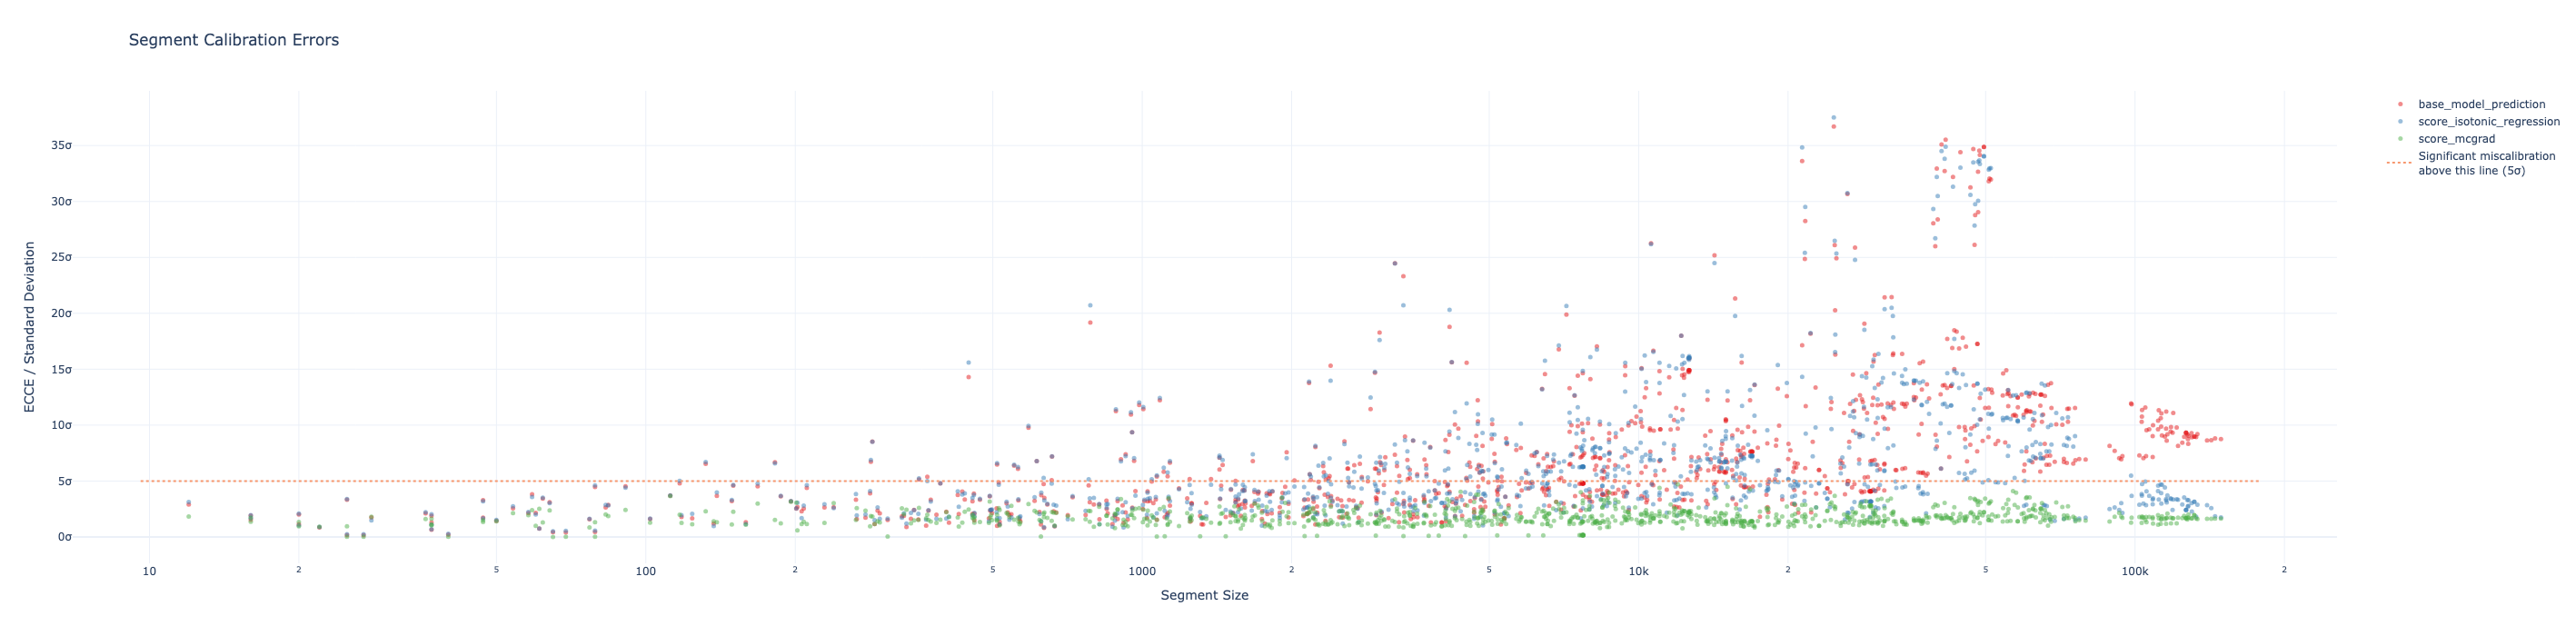

In [ ]:
combine_segment_calibration_plots(
    segment_plots=segment_plots,
    quantity="segments_ecce_sigma",
).update_layout(height=700, width=1000)

MCGrad reduced the ECCE σ for all segments below the 5σ significance threshold.

## 5. Hyperparameter Tuning

MCGrad's default hyperparameters work well in most cases, but you can tune them for better performance on your specific dataset. The `tuning` module provides `tune_mcgrad_params`, which uses Bayesian optimization to search over LightGBM parameters.

The tunable parameters include:
- `learning_rate`: Shrinkage rate for boosting (default search: 0.002–0.2)
- `n_estimators`: Number of boosting rounds per MCGrad iteration (default search: 10–500)
- `max_depth`: Maximum tree depth (default search: 2–15)
- `num_leaves`: Maximum leaves per tree (default search: 2–44)
- `min_child_samples`: Minimum samples per leaf (default search: 5–200)
- `lambda_l2`: L2 regularization (default search: 0–100)
- `min_gain_to_split`: Minimum gain to create a split (default search: 0–0.2)

For this demonstration, we use a smaller data sample to keep runtime short.

In [ ]:
from mcgrad.tuning import tune_mcgrad_params

# Sample a smaller subset for faster tuning demonstration
TUNING_SAMPLE_SIZE = 20000
tuning_df = train_df.sample(n=TUNING_SAMPLE_SIZE, random_state=42)
print(f"Tuning data size: {len(tuning_df)}")

We create a fresh MCGrad instance for tuning. The tuner will search for optimal LightGBM parameters while respecting other settings like early stopping.

In [ ]:
mcgrad_for_tuning = methods.MCGrad()

The `tune_mcgrad_params` function runs Bayesian optimization. Key parameters:
- `n_trials`: Number of hyperparameter configurations to try (more trials = better results but longer runtime)
- `categorical_feature_column_names` / `numerical_feature_column_names`: Same segment features used for fitting

The function returns the fitted model with optimal parameters and a DataFrame of all trial results.

In [ ]:
tuned_mcgrad, tuning_results = tune_mcgrad_params(
    model=mcgrad_for_tuning,
    df_train=tuning_df,
    prediction_column_name=BASE_MODEL_PREDICTION_COLUMN,
    label_column_name=LABEL_COLUMN,
    categorical_feature_column_names=categorical_segment_features,
    numerical_feature_column_names=numerical_segment_features,
    n_trials=5,  # Use more trials (e.g., 20-50) for production
)

The tuning results DataFrame shows performance for each trial, sorted by validation loss. Lower `normalized_entropy` indicates better performance.

In [ ]:
tuning_results.head()

The best hyperparameters found during tuning are stored in the returned model's `lightgbm_params` attribute:

In [ ]:
print("Best hyperparameters found:")
for param, value in tuned_mcgrad.lightgbm_params.items():
    print(f"  {param}: {value}")

## Next Steps

This tutorial covered the core MCGrad workflow including hyperparameter tuning. For more information, see:

- [API documentation](https://mcgrad.readthedocs.io/en/latest/api/methods.html) - Complete reference for all MCGrad classes and methods
- [MCE metric details](https://facebookincubator.github.io/MCGrad/docs/measuring-multicalibration) - Understanding segment construction and statistical interpretation
- [Methodology](https://facebookincubator.github.io/MCGrad/docs/methodology) - Technical details of the MCGrad algorithm